## Collect all .raw file names in the input_dir directory

In [1]:
import pathlib
import numpy as np
import matplotlib.pyplot as plt
import datetime
import multiprocessing
import scipy.ndimage as ndimage

"""
name format is "IMG####_MMDD.hhmmss.xxx.raw"
where
- `IMG is literally "IMG"
- `####` is 0001 to 9999
- `MMDD` is month and day with leading zeros, like 0602
- `hhmmss` is hour, minute and second with leading zeros, like 172541
- `xxx` is microsecond with leading zeros, like 622
- `raw` is literally "raw"
"""
def read_raw_file(tuple):
	sequence, raw_file = tuple
	array_1d = np.fromfile(raw_file, dtype=np.dtype("<u2")) # little‑endian unsigned short
	array_2d = array_1d.reshape(2560, 2048)	# height, width

	TRIM_ADDITIONAL = 0
	TRIM_TOP = 12 + TRIM_ADDITIONAL
	TRIM_LEFT = 12 + TRIM_ADDITIONAL
	TRIM_RIGHT = 450 + TRIM_ADDITIONAL
	TRIM_BOTTOM = 12 + TRIM_ADDITIONAL
	array_crop = array_2d[TRIM_TOP:2560-TRIM_BOTTOM, TRIM_LEFT:2048-TRIM_RIGHT]  # Crop the array
	return sequence, array_crop

def get_dic_from_dir(input_dir):
	dic = {}
	raw_files = list(input_dir.glob("*.raw"))

	if not raw_files:
		print("No raw files found.")
		exit(1)

	is_first = True
	for raw_file in raw_files:
		#		  11111111112
		#012345678901234567890
		#IMG####_mmdd.HHMMSS.xxx.raw
		sequence = int(raw_file.stem[4:7])
		date_string = raw_file.stem[8:19]
		#print(f"Found raw file: {raw_file.name}, {sequence}, {date_string}")
		date_image = datetime.datetime.strptime(date_string, "%m%d.%H%M%S")

		if is_first:
			is_first = False
			date_first = date_image

		stamp = (date_image - date_first).total_seconds()
		dic[sequence] = {}
		dic[sequence]["raw_file"] = raw_file
		dic[sequence]["stamp"] = stamp
	
	pool = multiprocessing.Pool()
	list_tuple = [(sequence, dic[sequence]["raw_file"]) for sequence in dic.keys()]
	pool_results = pool.map(read_raw_file, list_tuple)
	pool.close()
	pool.join()

	for sequence, array_crop in pool_results:
		dic[sequence]["array"] = array_crop

	return dic



## Plot mean, stddev and stddev/mean

In [2]:
def plot_mean(dic, keyname, ax):
	list_x = []
	list_y = []

	for sequence in sorted(dic.keys()):
		stamp = dic[sequence]["stamp"]
		array = dic[sequence][keyname]
		mean = array.mean()
		list_x.append(stamp)
		list_y.append(mean)

	ax.plot(list_x, list_y)
	ax.set_title("Mean")

def plot_std(dic, keyname, ax):
	list_x = []
	list_y = []

	for sequence in sorted(dic.keys()):
		stamp = dic[sequence]["stamp"]
		array = dic[sequence][keyname]
		std = array.std()
		list_x.append(stamp)
		list_y.append(std)

	ax.plot(list_x, list_y)

def plot_cv(dic, keyname, ax):
	list_x = []
	list_y = []

	for sequence in sorted(dic.keys()):
		stamp = dic[sequence]["stamp"]
		array = dic[sequence][keyname]
		cv = array.std() / array.mean()
		list_x.append(stamp)
		list_y.append(cv)

	ax.plot(list_x, list_y)



## Pairing of [low and high]

In [3]:

def get_paired(dic):
	dic_pair = {}
	for sequence in sorted(dic.keys()):
		if sequence % 2 == 0:
			if sequence -1 not in dic_pair:
				# Cannot pair
				return None
			else:
				dic_pair[sequence-1]["array_high"] = dic[sequence]["array"]
		else:
			dic_pair[sequence] = dic[sequence]
			dic_pair[sequence]["array_low"] = dic[sequence]["array"]
	return dic_pair

input_dir_off = pathlib.Path("data/250605/off").resolve()
input_dir_on = pathlib.Path("data/250605/on").resolve()
dic_off = get_dic_from_dir(input_dir_off)
dic_on = get_dic_from_dir(input_dir_on)
dic_off_pair = get_paired(dic_off)
dic_on_pair = get_paired(dic_on)


In [4]:
def show_distribution(array, title):
	plt.figure(figsize=(8, 4))
	plt.hist(array.ravel(), bins=1000, color='gray')
	plt.title(title)
	plt.xlabel('Pixel Intensity')
	plt.ylabel('Frequency')
	plt.grid(False)
	plt.show()

def show_distribution_log_scale(array, title):
	fig, ax = plt.subplots(figsize=(8, 4))
	ax.hist(array.ravel(), bins=1000, color='gray')
	ax.set_title(title)
	ax.set_xlabel('Pixel Intensity')
	ax.set_ylabel('Frequency')
	ax.set_yscale('log')
	ax.grid(False)
	plt.show()

def img_show(array, title):
	# Calculate mean along each axis
	mean_x_axis = np.mean(array, axis=0) # Mean along columns
	mean_y_axis = np.mean(array, axis=1) # Mean along rows

	# Create subplots
	fig, ax = plt.subplots(1, 3, figsize=(12, 4)) # One row, three columns

	# Plot the image
	im = ax[0].imshow(array, cmap='rainbow') # Display image in 'rainbow' colormap
	ax[0].set_title('Original Image')
	ax[0].set_xlabel('X-axis (Columns)')
	ax[0].set_ylabel('Y-axis (Rows)')
	fig.colorbar(im, ax=ax[0], orientation='vertical', label='Intensity')


	# Plot the mean along the X-axis
	ax[1].plot(mean_x_axis)
	ax[1].set_title('Mean along X-axis')
	ax[1].set_xlabel('X-axis (Columns)')
	ax[1].set_ylabel('Mean Intensity')

	# Plot the mean along the Y-axis
	ax[2].plot(mean_y_axis, range(len(mean_y_axis))) # Plot against y-axis indices
	ax[2].set_title('Mean along Y-axis')
	ax[2].set_xlabel('Mean Intensity')
	ax[2].set_ylabel('Y-axis (Rows)')
	ax[2].invert_yaxis() # Invert y-axis to match image orientation

	plt.suptitle(title, fontsize=16)
	plt.tight_layout()
	plt.show()



## Mean of small areas

In [5]:
def get_mean_4_corners(array):
	# Get the mean intensity of the 4 corners
	CORNER_SIZE = 100
	array_corner = np.concatenate([
		array[0:CORNER_SIZE, 0:CORNER_SIZE],
		array[0:CORNER_SIZE, -CORNER_SIZE-1:-1],
		array[-CORNER_SIZE-1:-1, 0:CORNER_SIZE],
		array[-CORNER_SIZE-1:-1, -CORNER_SIZE-1:-1]
	])
	mean_4_corners = np.mean(array_corner)
	return mean_4_corners

def get_mean_center(array):
	# Get the mean intensity of the center.
	# center is manually defined as
	#   (1200, 1200) - (1300, 1300)
	array_center = array[1200:1300, 1200:1300]
	mean_center = np.mean(array_center)
	return mean_center



# intensity ratio of high vs. low

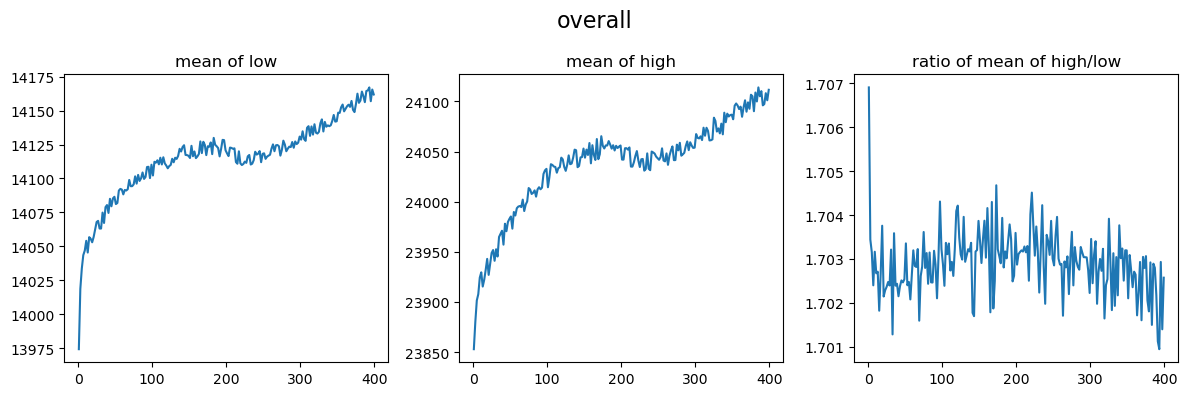

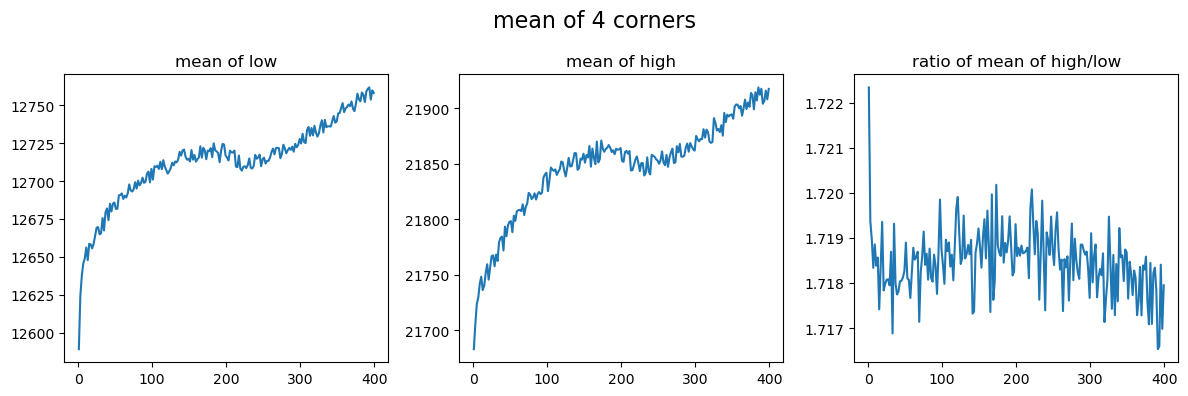

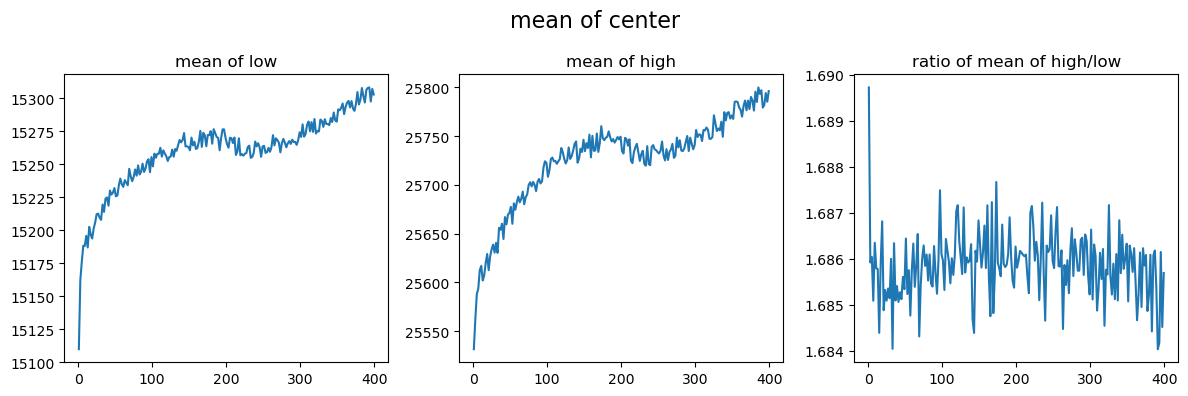

In [6]:
def plot_mean_ratio(list_mean_low, list_mean_high, title="mean ratio"):
	list_mean_ratio = [list_mean_high[x] / list_mean_low[x] for x in range(len(list_mean_low))]
	fig, axes = plt.subplots(1, 3, figsize=(12,4))
	axes[0].plot(list_sequence, list_mean_low)
	axes[0].set_title("mean of low")
	axes[1].plot(list_sequence, list_mean_high)
	axes[1].set_title("mean of high")
	axes[2].plot(list_sequence, list_mean_ratio)
	axes[2].set_title("ratio of mean of high/low")
	plt.suptitle(title, fontsize=16)
	plt.tight_layout()
	plt.show()

list_mean_low = []
list_mean_high = []
list_sequence = list(dic_off_pair.keys())
for sequence in list_sequence:
	mean_low = np.mean(dic_off_pair[sequence]["array_low"])
	mean_high = np.mean(dic_off_pair[sequence]["array_high"])
	list_mean_low.append(mean_low)
	list_mean_high.append(mean_high)
plot_mean_ratio(list_mean_low, list_mean_high, title="overall")

list_mean_low = []
list_mean_high = []
for sequence in list_sequence:
	mean_low = get_mean_4_corners(dic_off_pair[sequence]["array_low"])
	mean_high = get_mean_4_corners(dic_off_pair[sequence]["array_high"])
	list_mean_low.append(mean_low)
	list_mean_high.append(mean_high)

plot_mean_ratio(list_mean_low, list_mean_high, title="mean of 4 corners")

list_mean_low = []
list_mean_high = []
for sequence in list_sequence:
	mean_low = get_mean_center(dic_off_pair[sequence]["array_low"])
	mean_high = get_mean_center(dic_off_pair[sequence]["array_high"])
	list_mean_low.append(mean_low)
	list_mean_high.append(mean_high)
plot_mean_ratio(list_mean_low, list_mean_high, title="mean of center")



## Remove noise

In [7]:
def remove_noise(array):
	array_denoise = ndimage.median_filter(array, size=3) # median of 3x3
	return array_denoise

list_sequence = list(dic_off_pair.keys())

pool = multiprocessing.Pool()

pool_results = pool.map(remove_noise, [dic_off_pair[sequence]["array_low"] for sequence in list_sequence])
for sequence in list_sequence:
	dic_off_pair[sequence]["array_low_denoise"] = pool_results[list_sequence.index(sequence)]

pool_results = pool.map(remove_noise, [dic_off_pair[sequence]["array_high"] for sequence in list_sequence])
for sequence in list_sequence:
	dic_off_pair[sequence]["array_high_denoise"] = pool_results[list_sequence.index(sequence)]

pool.close()
pool.join()



## Plot means ratios

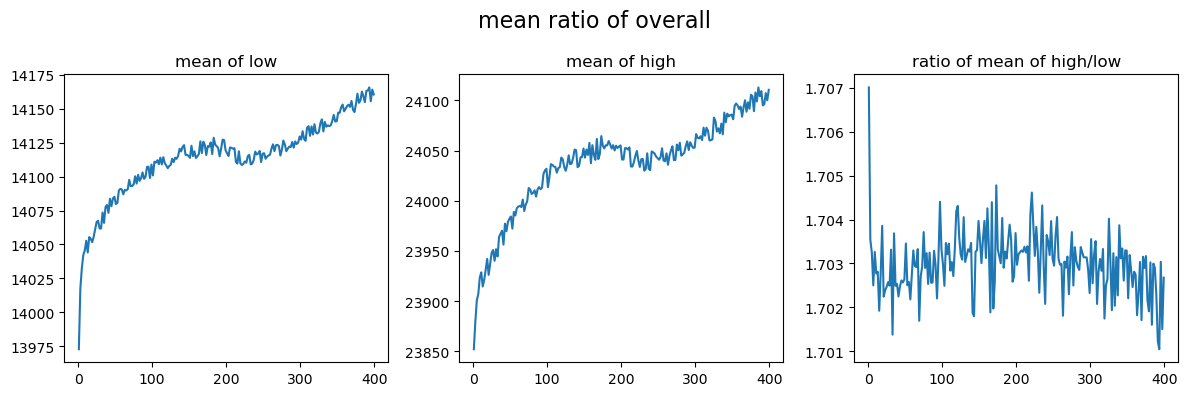

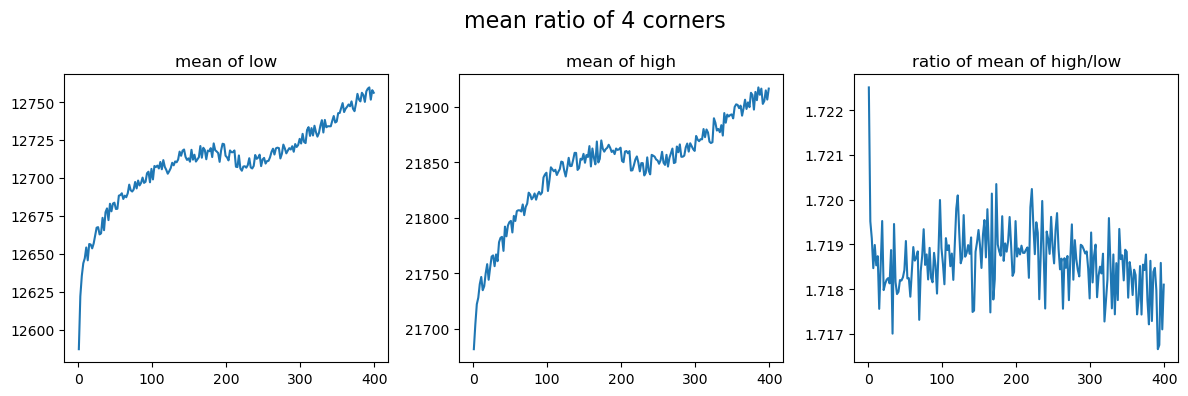

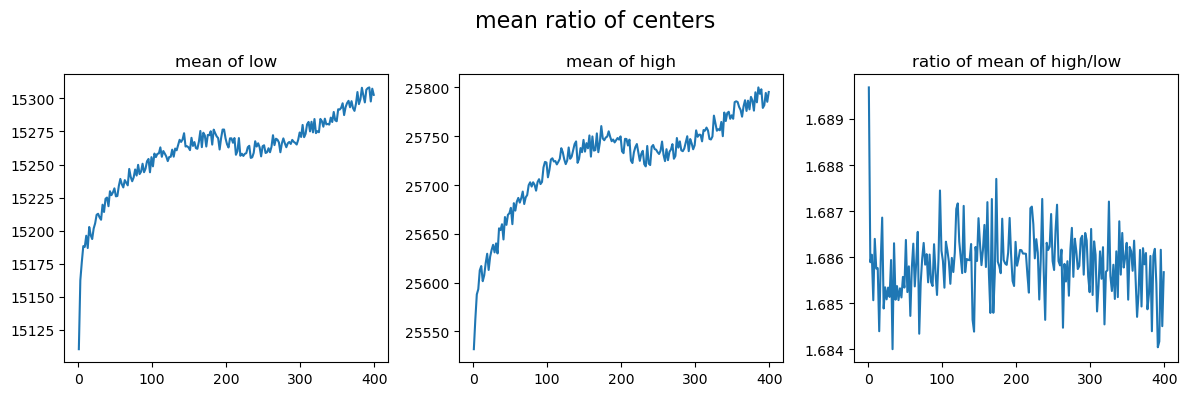

In [8]:
list_sequence = list(dic_off_pair.keys())
array_mean_low_overall = np.zeros(len(list_sequence))
array_mean_high_overall = np.zeros(len(list_sequence))
array_mean_low_corner = np.zeros(len(list_sequence))
array_mean_high_corner = np.zeros(len(list_sequence))
array_mean_low_center = np.zeros(len(list_sequence))
array_mean_high_center = np.zeros(len(list_sequence))

for i, sequence in enumerate(list_sequence):
	array_mean_low_overall[i] = np.mean(dic_off_pair[sequence]["array_low_denoise"])
	array_mean_high_overall[i] = np.mean(dic_off_pair[sequence]["array_high_denoise"])

	array_mean_low_corner[i] = get_mean_4_corners(dic_off_pair[sequence]["array_low_denoise"])
	array_mean_high_corner[i] = get_mean_4_corners(dic_off_pair[sequence]["array_high_denoise"])

	array_mean_low_center[i] = get_mean_center(dic_off_pair[sequence]["array_low_denoise"])
	array_mean_high_center[i] = get_mean_center(dic_off_pair[sequence]["array_high_denoise"])

plot_mean_ratio(array_mean_low_overall, array_mean_high_overall, title="mean ratio of overall")
plot_mean_ratio(array_mean_low_corner, array_mean_high_corner, title="mean ratio of 4 corners")
plot_mean_ratio(array_mean_low_center, array_mean_high_center, title="mean ratio of centers")



## save ratio data for future machine learning

### array_learning.csv format
"""
	LP, HP, LC, HC

	where
		LP is a mean of intensity values, pheriperal areas of LOW image.
		HP is a mean of intensity values, pheriperal areas of HIGH image.
		LC is a mean of intensity values, central area of LOW image.
		HC is a mean of intensity values, central area of HIGH image.
	
		LP and HP are given input values
		LC and HC are output values to predict.
"""

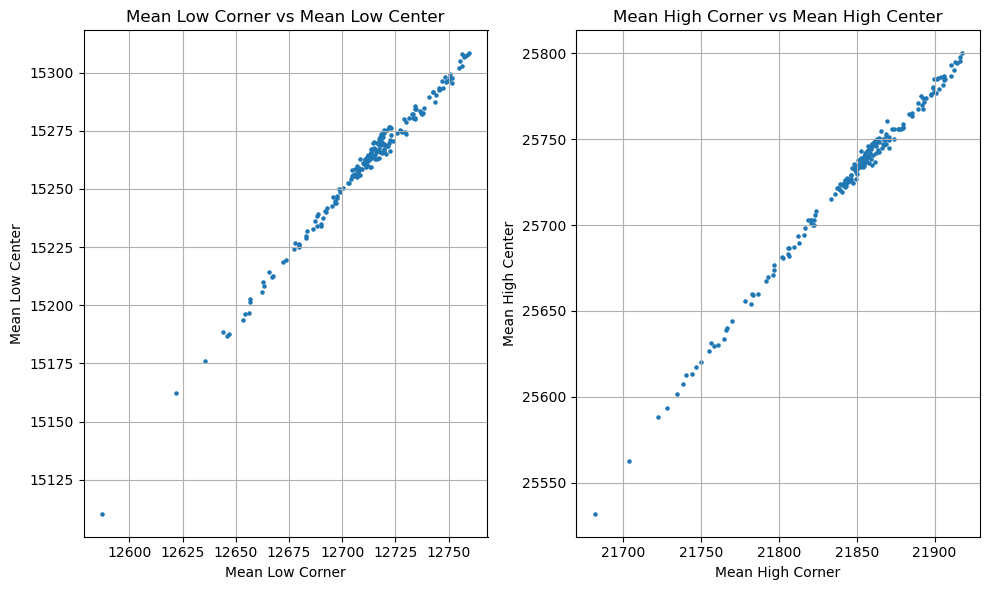

In [9]:
list_sequence = list(dic_off_pair.keys())
array_learning = np.array([array_mean_low_corner, array_mean_high_corner, array_mean_low_center, array_mean_high_center])
array_learning = array_learning.T  # Transpose to have each row as a sequence
np.savetxt("array_learning.csv", array_learning, delimiter=",", fmt="%7.2f")

array_mean_low_corner = np.array(array_mean_low_corner)
fig, ax = plt.subplots(1, 2, figsize=(10, 6))
ax[0].scatter(array_mean_low_corner, array_mean_low_center, s=5)
ax[0].set_title("Mean Low Corner vs Mean Low Center")
ax[0].set_xlabel("Mean Low Corner")
ax[0].set_ylabel("Mean Low Center")
ax[0].grid()

ax[1].scatter(array_mean_high_corner, array_mean_high_center, s=5)
ax[1].set_title("Mean High Corner vs Mean High Center")
ax[1].set_xlabel("Mean High Corner")
ax[1].set_ylabel("Mean High Center")
ax[1].grid()

plt.tight_layout()
plt.show()


## HIGH/LOW ratio is 1.6858, from machine learning.

For more info, please refer `torch_regression.py`

In [10]:
RATIO_HIGH_OVER_LOW = 1.6858
INTENSITY_CENTER_LOW = 15260
INTENSITY_CENTER_HIGH = 25726

## ratio of high over low, for OFF images

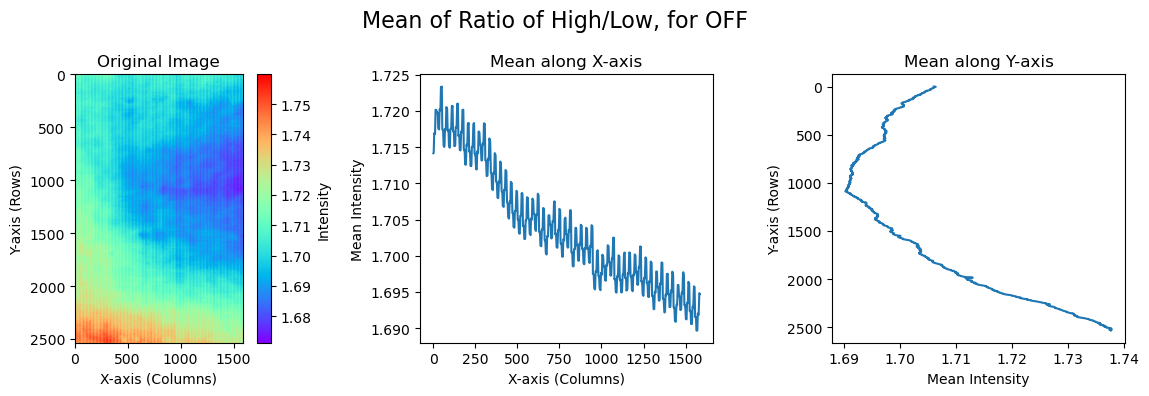

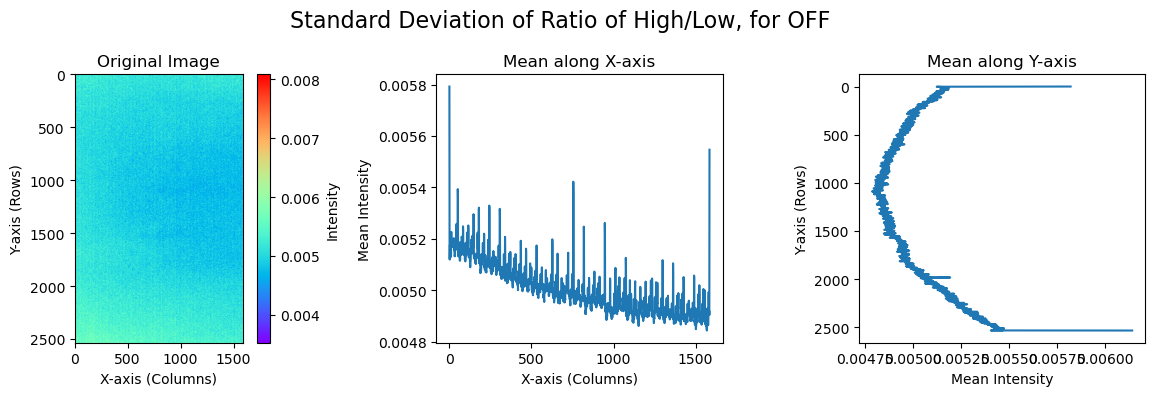

In [11]:
list_sequence = list(dic_off_pair.keys())
for sequence in list_sequence:
	# be careful with division by zero
	dic_off_pair[sequence]["array_ratio"] = dic_off_pair[sequence]["array_high_denoise"] / (dic_off_pair[sequence]["array_low_denoise"] + 1e-8)

array_ratio_mean = np.mean([dic_off_pair[sequence]["array_ratio"] for sequence in list_sequence], axis=0)
img_show(array_ratio_mean, title="Mean of Ratio of High/Low, for OFF")

array_ratio_std = np.std([dic_off_pair[sequence]["array_ratio"] for sequence in list_sequence], axis=0)
img_show(array_ratio_std, title="Standard Deviation of Ratio of High/Low, for OFF")


## ratio of high over low, for ON images

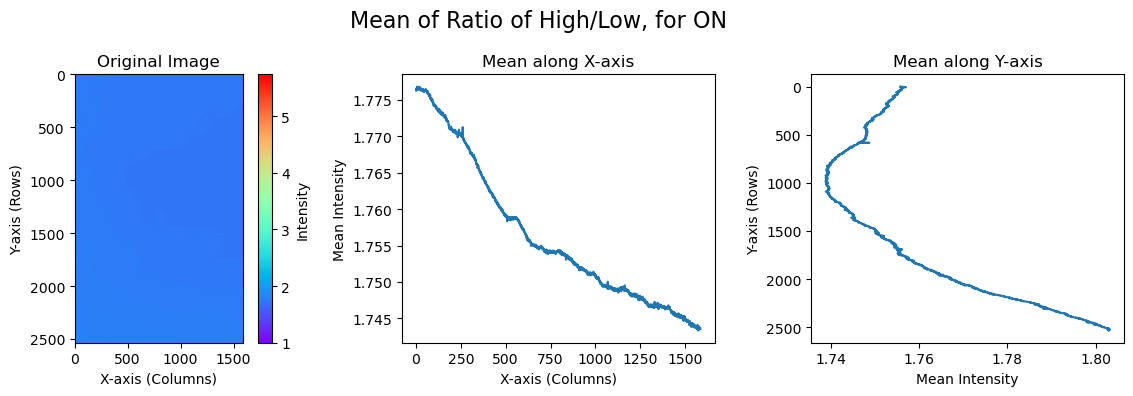

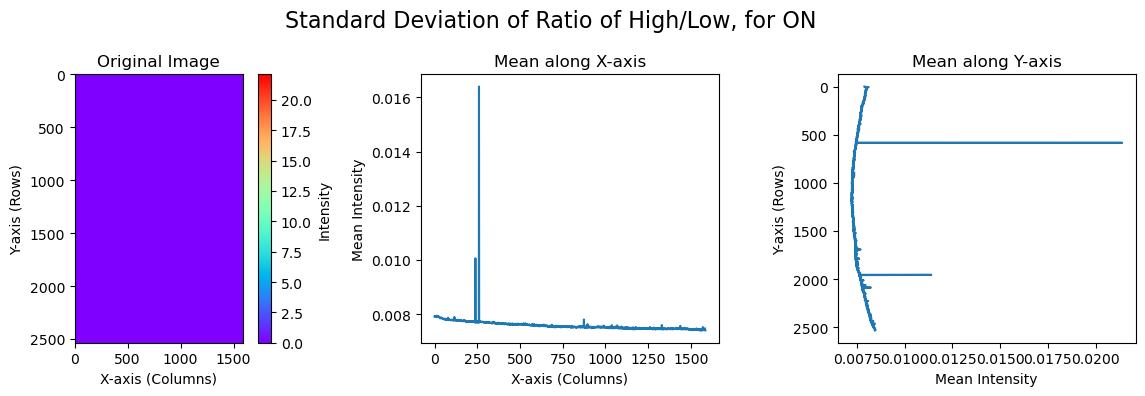

In [12]:
list_sequence = list(dic_on_pair.keys())
for sequence in list_sequence:
	dic_on_pair[sequence]["array_ratio"] = dic_on_pair[sequence]["array_high"] / dic_on_pair[sequence]["array_low"]

array_ratio_mean = np.mean([dic_on_pair[sequence]["array_ratio"] for sequence in list_sequence], axis=0)
img_show(array_ratio_mean, title="Mean of Ratio of High/Low, for ON")

array_ratio_std = np.std([dic_on_pair[sequence]["array_ratio"] for sequence in list_sequence], axis=0)
img_show(array_ratio_std, title="Standard Deviation of Ratio of High/Low, for ON")



## sample ratio of an image

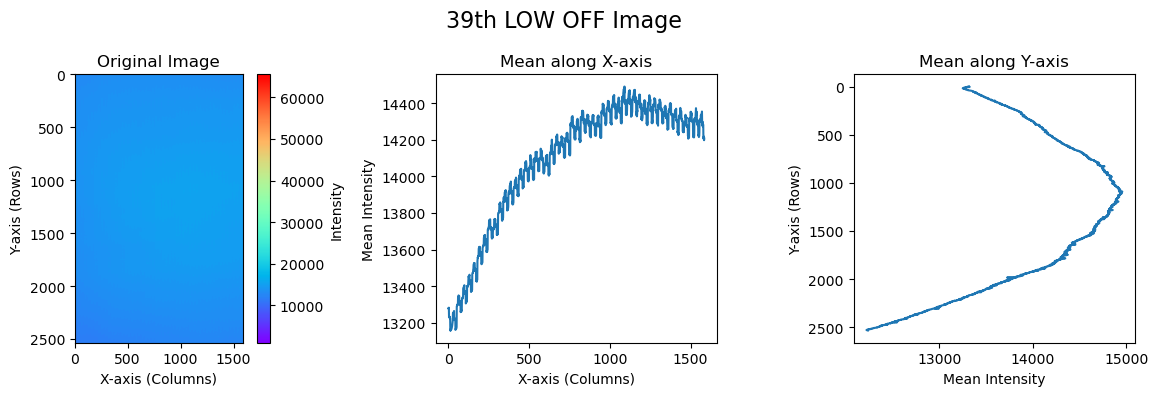

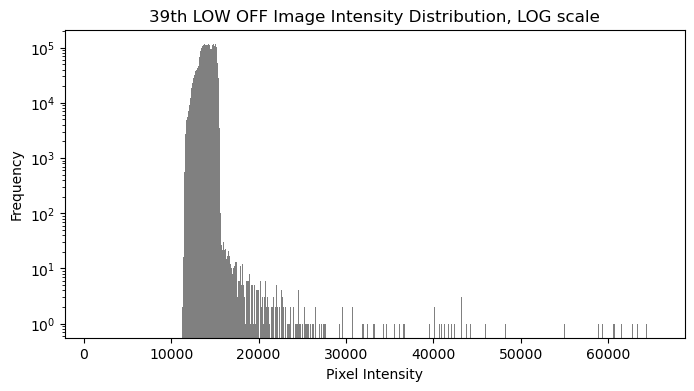

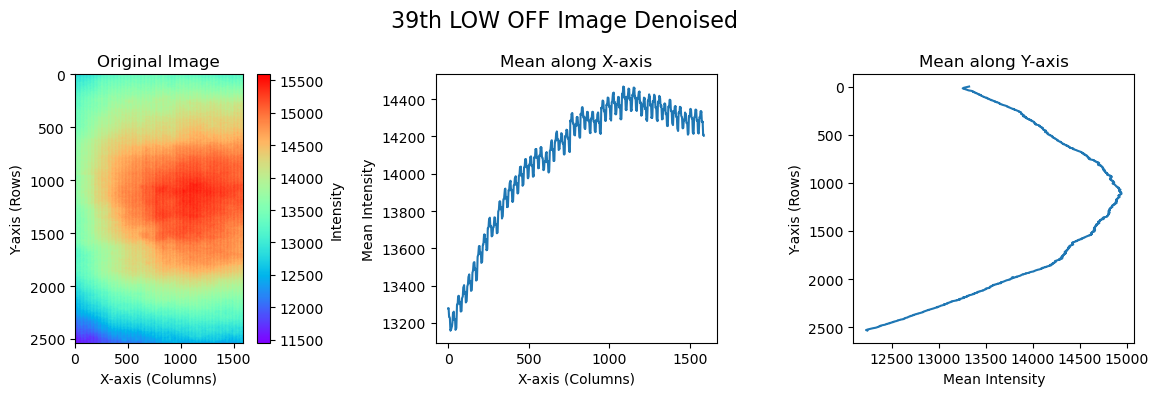

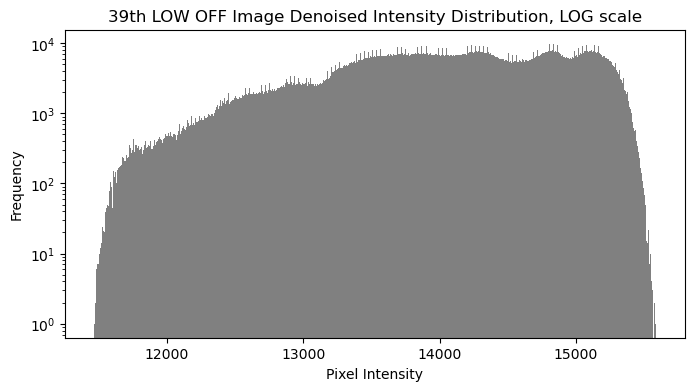

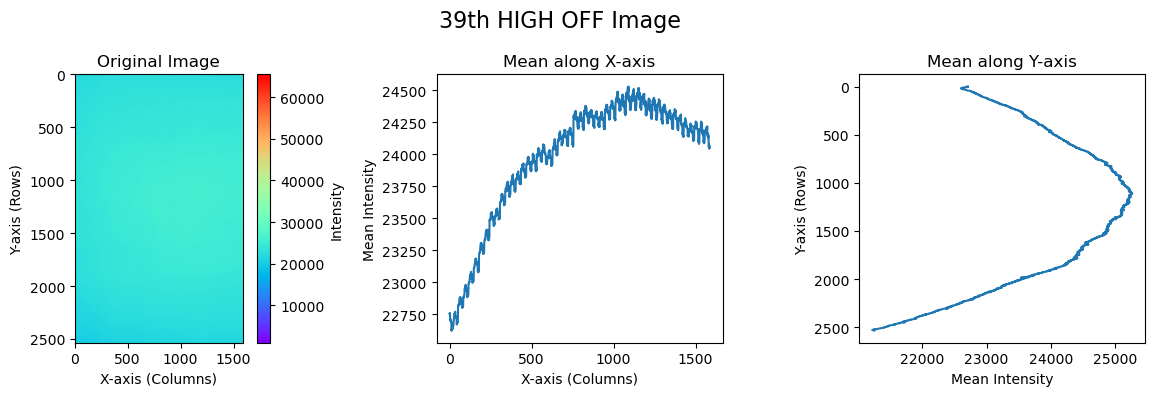

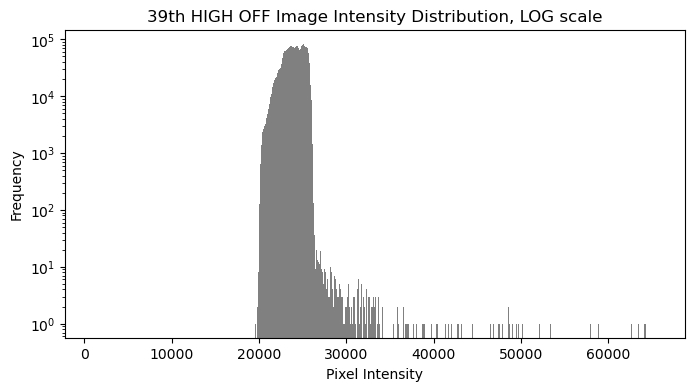

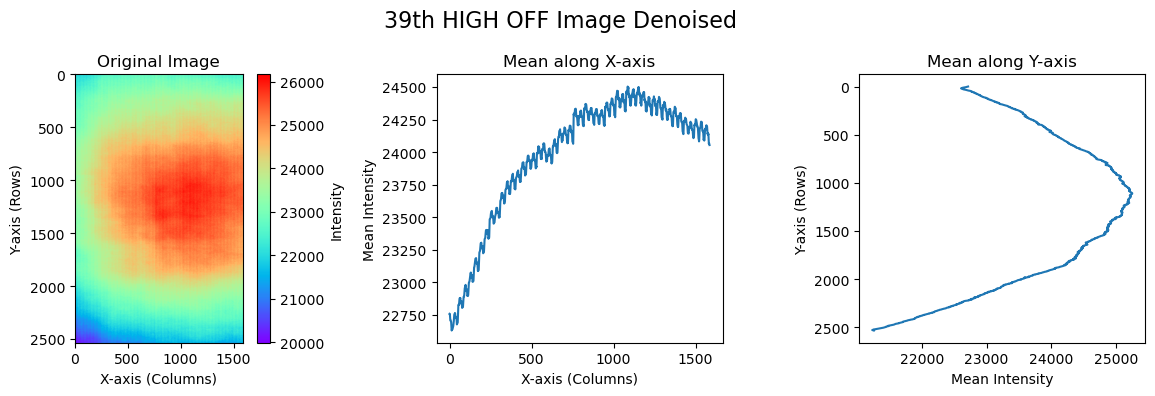

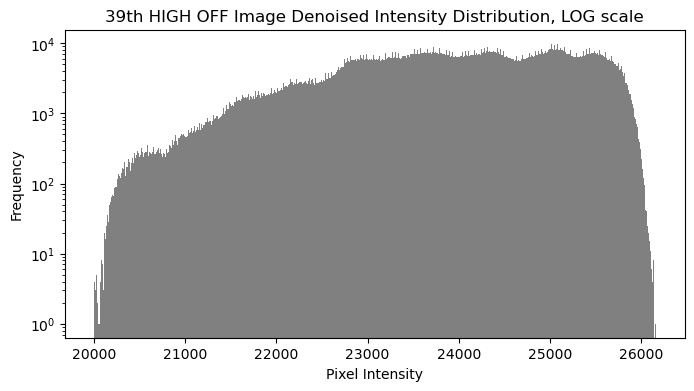

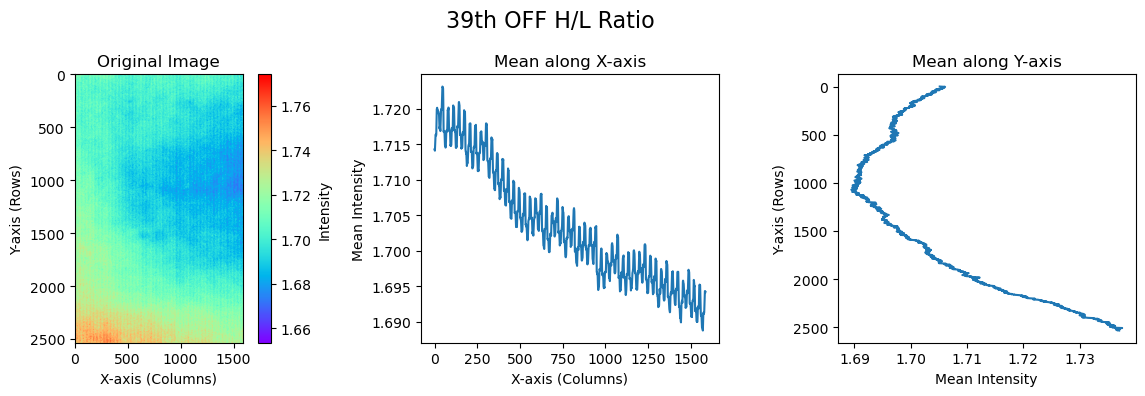

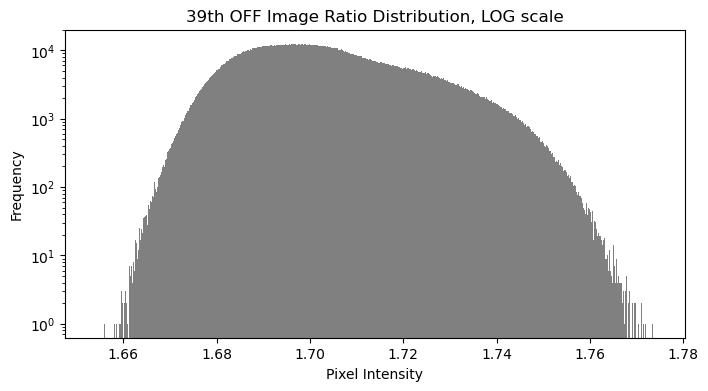

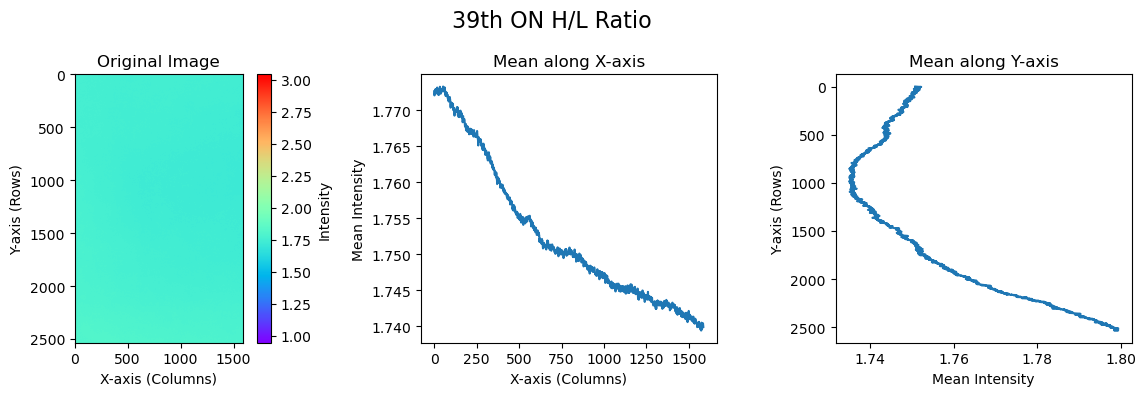

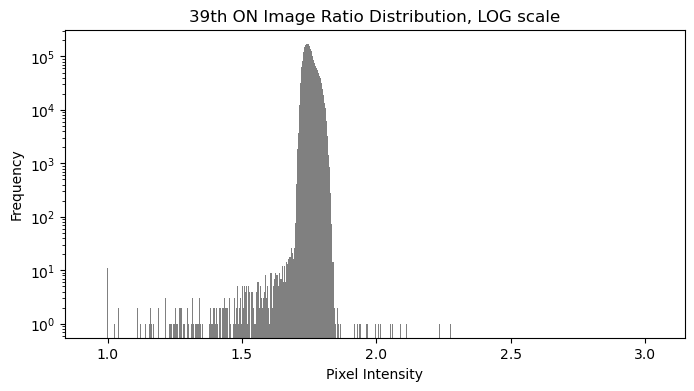

In [13]:
index_sample = 39
array_low = dic_off_pair[index_sample]["array_low"]
array_high = dic_off_pair[index_sample]["array_high"]
array_low_denoise = dic_off_pair[index_sample]["array_low_denoise"]
array_high_denoise = dic_off_pair[index_sample]["array_high_denoise"]

img_show(array_low, f"{index_sample}th LOW OFF Image")
show_distribution_log_scale(array_low, f"{index_sample}th LOW OFF Image Intensity Distribution, LOG scale")

img_show(array_low_denoise, f"{index_sample}th LOW OFF Image Denoised")
show_distribution_log_scale(array_low_denoise, f"{index_sample}th LOW OFF Image Denoised Intensity Distribution, LOG scale")

img_show(array_high, f"{index_sample}th HIGH OFF Image")
show_distribution_log_scale(array_high, f"{index_sample}th HIGH OFF Image Intensity Distribution, LOG scale")

img_show(array_high_denoise, f"{index_sample}th HIGH OFF Image Denoised")
show_distribution_log_scale(array_high_denoise, f"{index_sample}th HIGH OFF Image Denoised Intensity Distribution, LOG scale")

array_off_ratio = dic_off_pair[index_sample]["array_ratio"]
img_show(array_off_ratio, f"{index_sample}th OFF H/L Ratio")
plt.imsave("array_off_ratio.png", array_off_ratio, format="png", cmap='rainbow')
show_distribution_log_scale(array_off_ratio, f"{index_sample}th OFF Image Ratio Distribution, LOG scale")

array_on_ratio = dic_on_pair[index_sample]["array_ratio"]
img_show(array_on_ratio, f"{index_sample}th ON H/L Ratio")
plt.imsave("array_on_ratio.png", array_on_ratio, format="png", cmap='rainbow')
show_distribution_log_scale(array_on_ratio, f"{index_sample}th ON Image Ratio Distribution, LOG scale")


## Correction algorithm

In [14]:
def get_correction_matrix(array, target_intensity):
	mean_4_corners = get_mean_4_corners(array)
	array_correction = target_intensity * mean_4_corners / array.astype(float)
	return array_correction

def get_corrected_matrix(array, array_correction):
	mean_4_corners = get_mean_4_corners(array)
	array_corrected = array.astype(float) * array_correction / mean_4_corners
	return array_corrected.astype(np.uint16)


## Generate correction matrix and save to files

In [15]:
array_correction_low_sum = np.zeros((dic_off_pair[1]["array_low_denoise"].shape), dtype=np.float64)
array_correction_high_sum = np.zeros((dic_off_pair[1]["array_high_denoise"].shape), dtype=np.float64)
for sequence in dic_off_pair.keys():
	array_correction_low_sum += get_correction_matrix(dic_off_pair[sequence]["array_low_denoise"], INTENSITY_CENTER_LOW)
	array_correction_high_sum += get_correction_matrix(dic_off_pair[sequence]["array_high_denoise"], INTENSITY_CENTER_HIGH)

array_correction_low_mean = array_correction_low_sum / len(dic_off_pair)
array_correction_high_mean = array_correction_high_sum / len(dic_off_pair)
np.savetxt(pathlib.Path("correction_low.csv").resolve(), array_correction_low_mean, fmt="%.3f", delimiter=",")
np.savetxt(pathlib.Path("correction_high.csv").resolve(), array_correction_high_mean, fmt="%.3f", delimiter=",")
array_correction_low_mean.astype(np.uint16).tofile(pathlib.Path("correction_low_uint16.raw").resolve(), format="raw")
array_correction_high_mean.astype(np.uint16).tofile(pathlib.Path("correction_high_uint16.raw").resolve(), format="raw")


## Do some corrections

In [16]:
for key in dic_off_pair:
    dic_off_pair[key]["array_low_corrected"] = get_corrected_matrix(dic_off_pair[key]["array_low_denoise"], array_correction_low_mean)
    dic_off_pair[key]["array_high_corrected"] = get_corrected_matrix(dic_off_pair[key]["array_high_denoise"], array_correction_high_mean)

## Show some corrected images

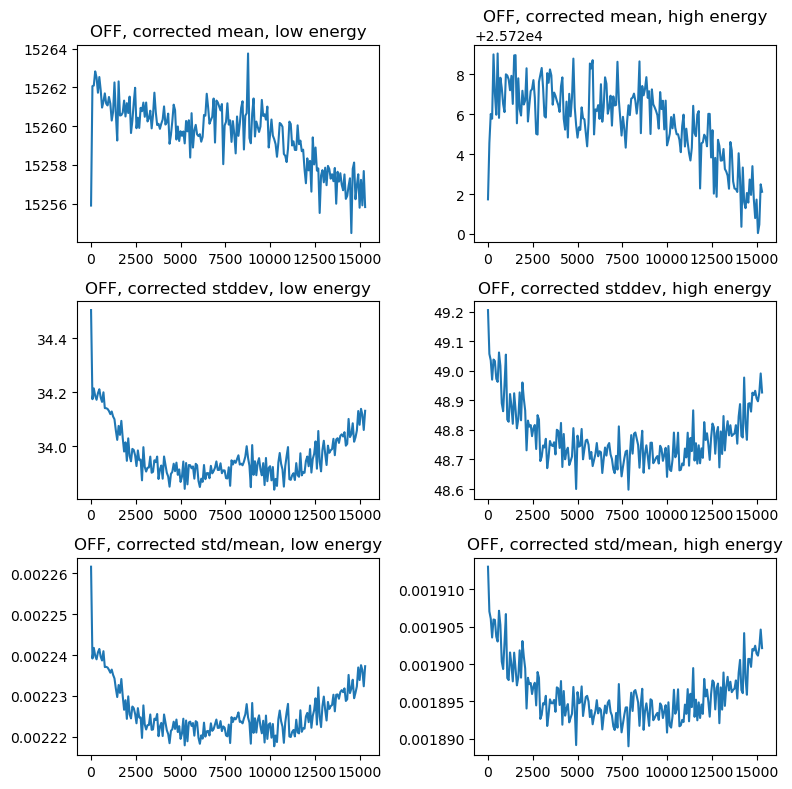

In [17]:
fig, axs = plt.subplots(3, 2, figsize=(8, 8))
plot_mean(dic_off_pair, "array_low_corrected", ax=axs[0, 0])
plot_std(dic_off_pair, "array_low_corrected", ax=axs[1, 0])
plot_cv(dic_off_pair, "array_low_corrected", ax=axs[2, 0])
plot_mean(dic_off_pair, "array_high_corrected", ax=axs[0, 1])
plot_std(dic_off_pair, "array_high_corrected", ax=axs[1, 1])
plot_cv(dic_off_pair, "array_high_corrected", ax=axs[2, 1])
axs[0, 0].set_title("OFF, corrected mean, low energy")
axs[1, 0].set_title("OFF, corrected stddev, low energy")
axs[2, 0].set_title("OFF, corrected std/mean, low energy")
axs[0, 1].set_title("OFF, corrected mean, high energy")
axs[1, 1].set_title("OFF, corrected stddev, high energy")
axs[2, 1].set_title("OFF, corrected std/mean, high energy")
plt.tight_layout()
plt.show()

## Correction sample, 39th image

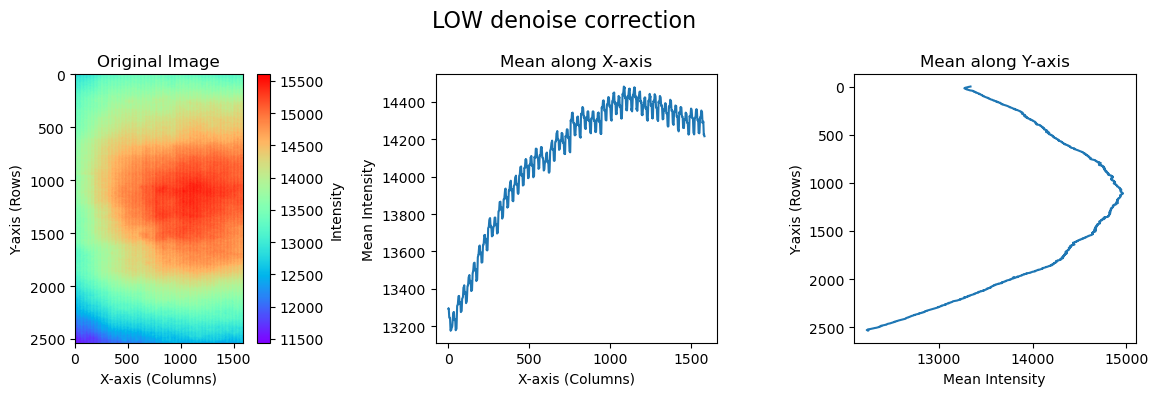

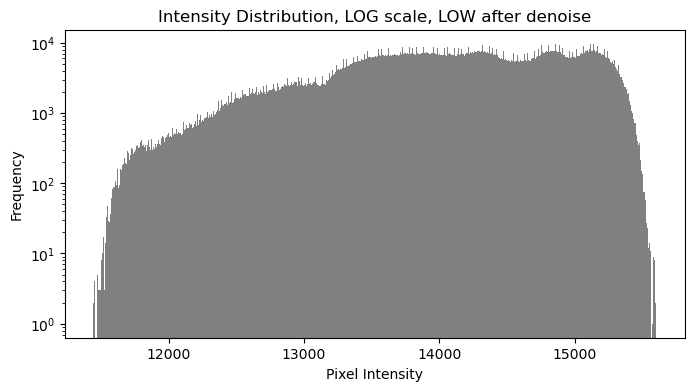

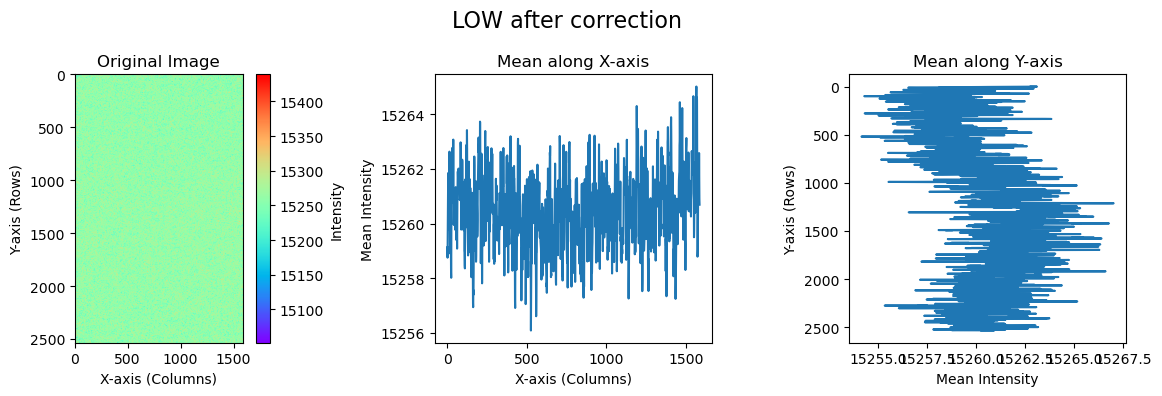

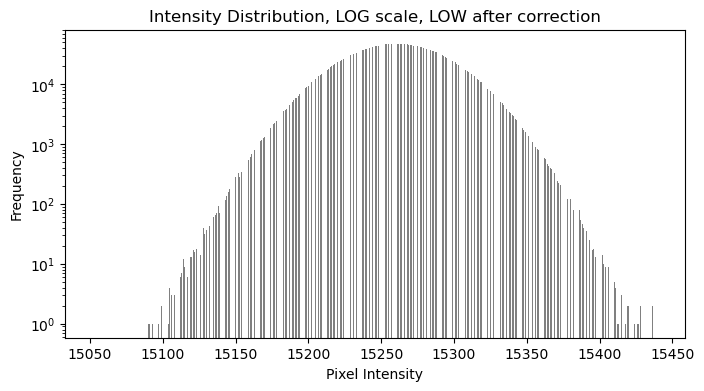

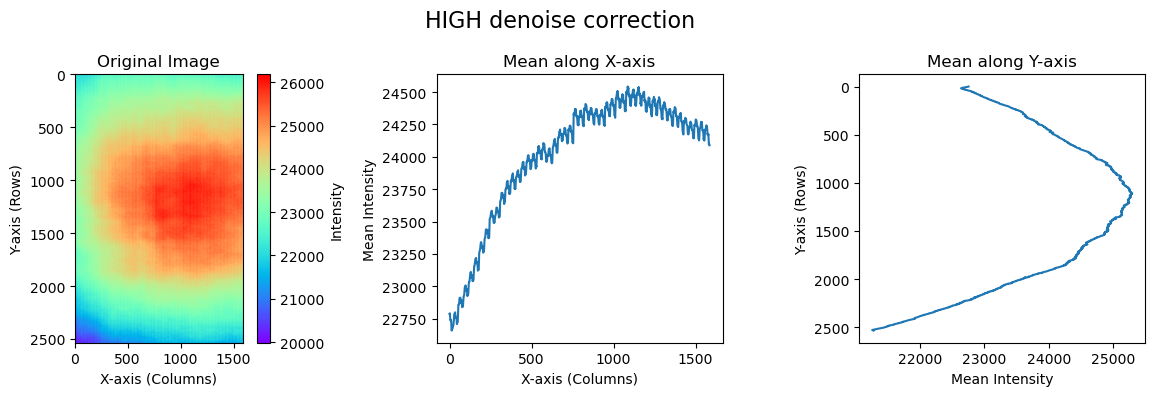

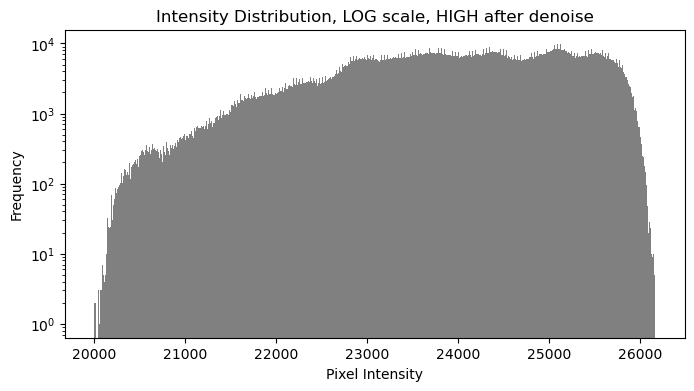

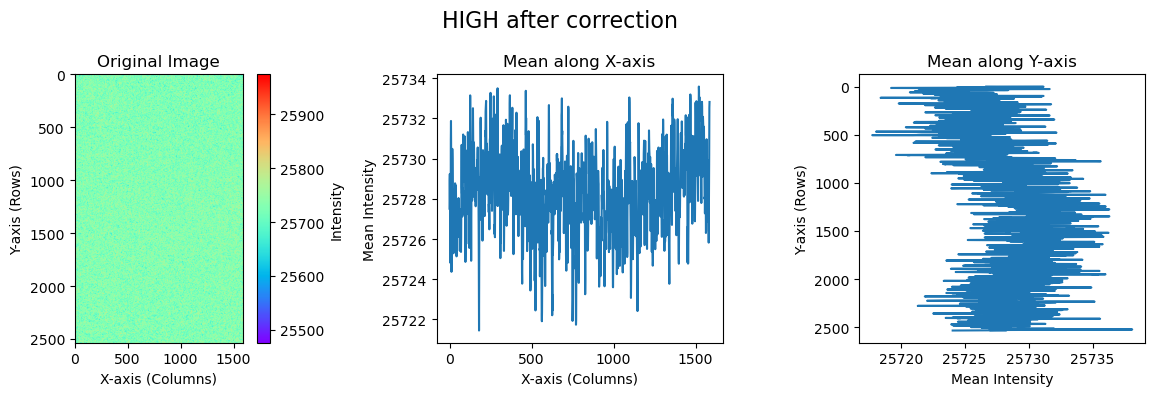

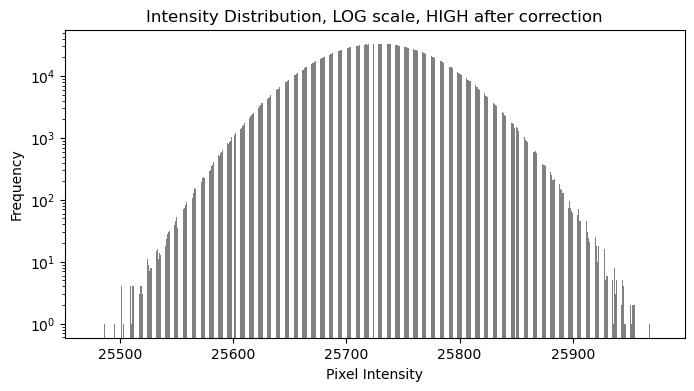

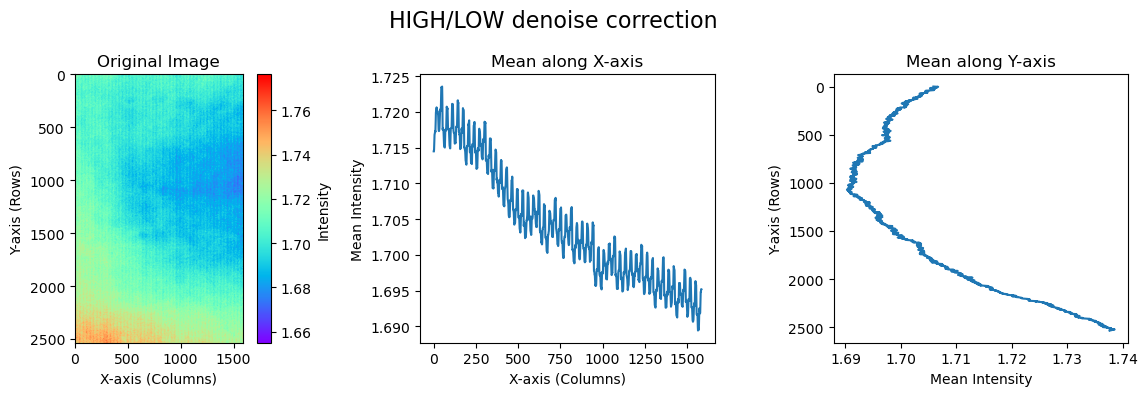

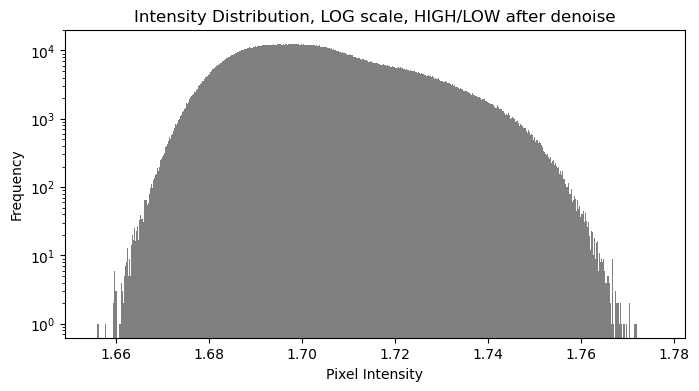

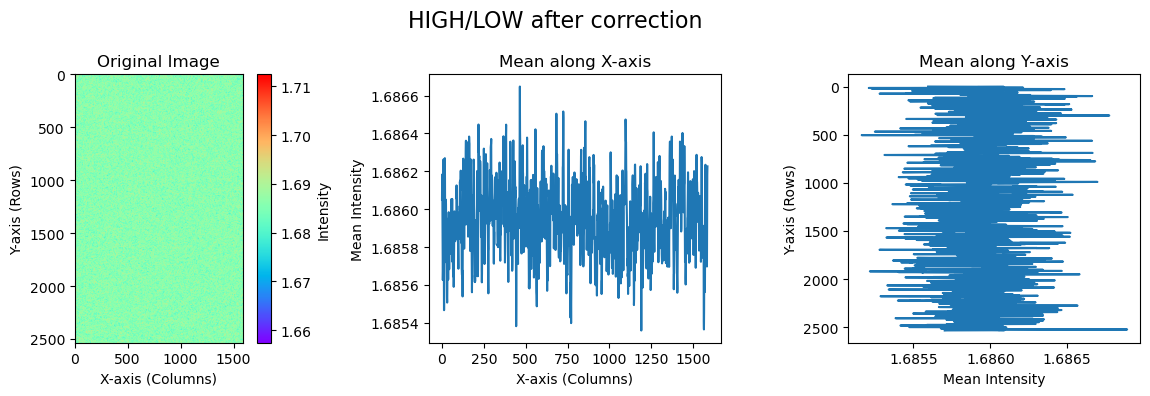

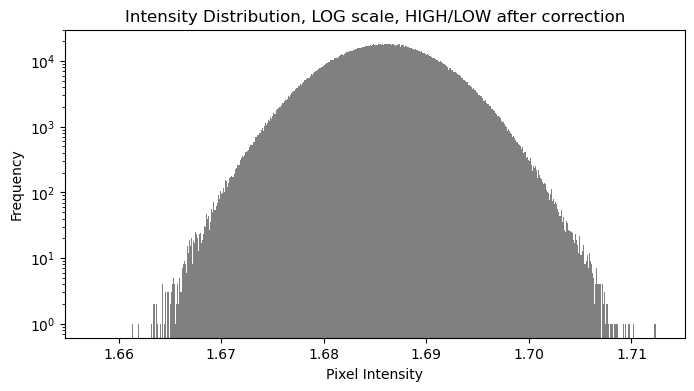

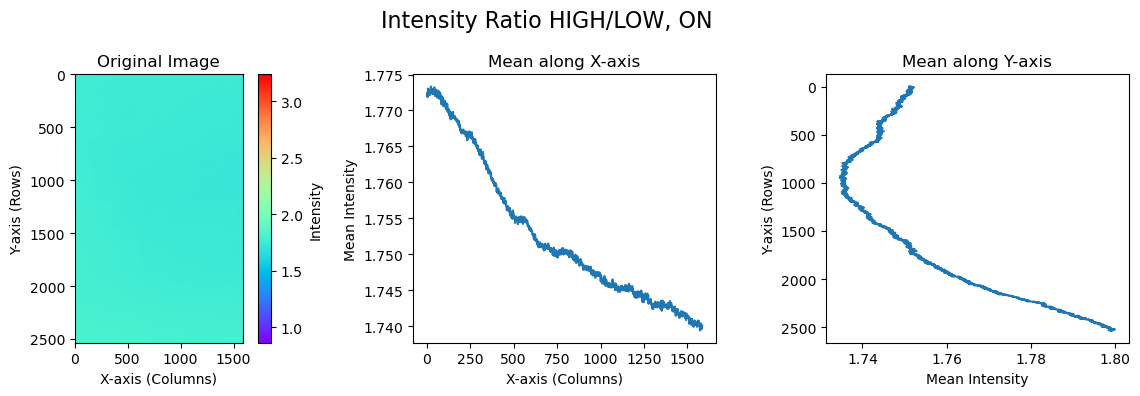

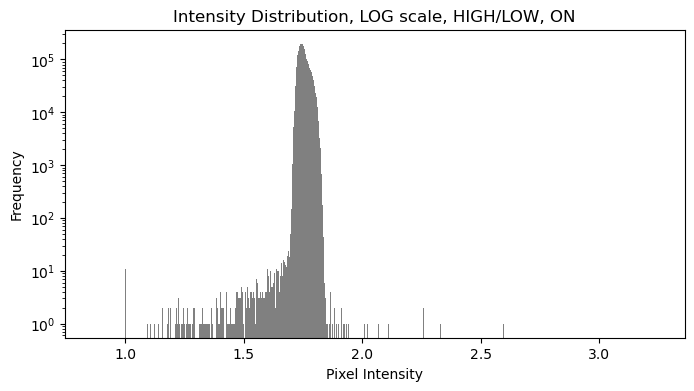

coefficient of variation: LOW  off        : 0.05770069544230392
coefficient of variation: LOW  denoise    : 0.05642679136904997
coefficient of variation: LOW  correction : 0.0022229999891818955
coefficient of variation: LOW  on         : 0.014061219829053671

coefficient of variation: HIGH off        : 0.04904043890325775
coefficient of variation: HIGH denoise    : 0.04853575773172286
coefficient of variation: HIGH correction : 0.0018932147637465164
coefficient of variation: HIGH on         : 0.009793527235341128

coefficient of variation: HIGH/LOW off        : 0.01027142667578407
coefficient of variation: HIGH/LOW denoise    : 0.009617230860218968
coefficient of variation: HIGH/LOW correction : 0.0029140002087132038
coefficient of variation: HIGH/LOW on         : 0.012434464184521444


In [20]:
index_sample = 39
key_sample = list(dic_off_pair.keys())[index_sample]
array_low_off = dic_off_pair[key_sample]["array_low"]
array_low_denoise = dic_off_pair[key_sample]["array_low_denoise"]
array_low_after = dic_off_pair[key_sample]["array_low_corrected"]
array_high_off = dic_off_pair[key_sample]["array_high"]
array_high_denoise = dic_off_pair[key_sample]["array_high_denoise"]
array_high_after = dic_off_pair[key_sample]["array_high_corrected"]
array_high_over_low_off = array_high_off / array_low_off
array_high_over_low_denoise = array_high_denoise / array_low_denoise
array_high_over_low_after = array_high_after / array_low_after

img_show(array_low_denoise, "LOW denoise correction")
show_distribution_log_scale(array_low_denoise, "Intensity Distribution, LOG scale, LOW after denoise")
img_show(array_low_after, "LOW after correction")
show_distribution_log_scale(array_low_after, "Intensity Distribution, LOG scale, LOW after correction")
img_show(array_high_denoise, "HIGH denoise correction")
show_distribution_log_scale(array_high_denoise, "Intensity Distribution, LOG scale, HIGH after denoise")
img_show(array_high_after, "HIGH after correction")
show_distribution_log_scale(array_high_after, "Intensity Distribution, LOG scale, HIGH after correction")
img_show(array_high_over_low_denoise, "HIGH/LOW denoise correction")
show_distribution_log_scale(array_high_over_low_denoise, "Intensity Distribution, LOG scale, HIGH/LOW after denoise")
img_show(array_high_over_low_after, "HIGH/LOW after correction")
show_distribution_log_scale(array_high_over_low_after, "Intensity Distribution, LOG scale, HIGH/LOW after correction")

array_high_over_low_on = dic_on_pair[key_sample]["array_high"] / dic_on_pair[key_sample]["array_low"]
img_show(array_high_over_low_on, "Intensity Ratio HIGH/LOW, ON")
show_distribution_log_scale(array_high_over_low_on, "Intensity Distribution, LOG scale, HIGH/LOW, ON")

# Calculate coefficient of variation CV, which is normalized root mean square deviation
cv_low_off = array_low_off.std() / array_low_off.mean()
cv_low_denoise = array_low_denoise.std() / array_low_denoise.mean()
cv_low_after = array_low_after.std() / array_low_after.mean()
cv_low_on = dic_on_pair[key_sample]["array_low"].std() / dic_on_pair[key_sample]["array_low"].mean()
print(f"coefficient of variation: LOW  off        : {cv_low_off}")
print(f"coefficient of variation: LOW  denoise    : {cv_low_denoise}")
print(f"coefficient of variation: LOW  correction : {cv_low_after}")
print(f"coefficient of variation: LOW  on         : {cv_low_on}")
print("")

cv_high_off = array_high_off.std() / array_high_off.mean()
cv_high_denoise = array_high_denoise.std() / array_high_denoise.mean()
cv_high_after = array_high_after.std() / array_high_after.mean()
cv_high_on = dic_on_pair[key_sample]["array_high"].std() / dic_on_pair[key_sample]["array_high"].mean()
print(f"coefficient of variation: HIGH off        : {cv_high_off}")
print(f"coefficient of variation: HIGH denoise    : {cv_high_denoise}")
print(f"coefficient of variation: HIGH correction : {cv_high_after}")
print(f"coefficient of variation: HIGH on         : {cv_high_on}")
print("")

cv_high_over_low_off = array_high_over_low_off.std() / array_high_over_low_off.mean()
cv_high_over_low_denoise = array_high_over_low_denoise.std() / array_high_over_low_denoise.mean()
cv_high_over_low_after = array_high_over_low_after.std() / array_high_over_low_after.mean()
cv_high_over_low_on = array_high_over_low_on.std() / array_high_over_low_on.mean()
print(f"coefficient of variation: HIGH/LOW off        : {cv_high_over_low_off}")
print(f"coefficient of variation: HIGH/LOW denoise    : {cv_high_over_low_denoise}")
print(f"coefficient of variation: HIGH/LOW correction : {cv_high_over_low_after}")
print(f"coefficient of variation: HIGH/LOW on         : {cv_high_over_low_on}")
